# Multirate mixer

Author: Eric Kooistra, May 2024

Purpose:
* Practise DSP [1].
* Use multirate processing to implement a mixer 

References:
1. dsp_study_erko, summary of DSP books
2. chapter 6 downconverter, 7 upconverter, 9 filterbank in [HARRIS]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from fractions import Fraction

In [2]:
# Auto reload module when it is changed
%load_ext autoreload
%autoreload 2

# Add rtdsp module path to $PYTHONPATH
import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)

# Import rtdsp
from rtdsp.utilities import verify_result, is_integer_value, is_symmetrical, pow_db
from rtdsp.firfilter import filterbank_frequency_response
from rtdsp.fourier import dtft
from rtdsp.multirate import down, up, maximal_downsample_bpf, non_maximal_downsample_bpf
from rtdsp.plotting import plot_power_spectrum, plot_magnitude_spectrum

# 0 Time, bins and rates

In [3]:
# Filterbank
Ntaps = 8  # number of taps per poly phase FIR filter
Ndft = 16  # DFT size
Ncoefs = Ndft * Ntaps
#Ncoefs = Ncoefs - 1   # try odd length

# Waveform generator
wg_sub = 1.0  # in range(Nsub)
print('wg_sub   =', wg_sub)

# Mixer LO bin
kLo = int(np.round(wg_sub))
print('kLo      =', kLo)

# Downsample rate
Ndown = Ndft * 3 // 4
#Ndown = Ndft
Ros = Fraction(Ndft, Ndown)
print()
print('Ros      =', Ros)
print('. Ndown  =', Ndown)
print('. Ndft   =', Ndft)

wg_sub   = 1.0
kLo      = 1

Ros      = 4/3
. Ndown  = 12
. Ndft   = 16


In [4]:
# Samples
fs = 1.0  # sample rate
Ts = 1 / fs  # sample period

In [5]:
# Subbands
Nsub = Ndft // 2  # number of subbands in fs / 2
fsub = fs / Ndft  # subband center frequency
Tsub = 1 / fsub  # subband period

fdown = fs / Ndown  # downsampled data rate
Tdown = 1 / fdown  # downsampled data period 

In [6]:
# Time
# . number of subband periods to simulate 
Nsim = 15

# . number input samples to simulate 
Nsamples = Nsim * Ndft
# . input time index n for up rate
n_i = np.arange(Nsamples)  # sample index, time in sample period units [Ts]
n_s = n_i * Ts  # time in seconds
n_sub = n_s / Ndft  # time in subband period units [Tsub]

# . number of downsampled samples
Msamples = Nsamples // Ndown
# . downsampled time index m for down rate, n = m D, so m = n // D
m_i = np.arange(Msamples)  # downsampled sample index
m_s = down(n_s, Ndown)  # = m_i * Tdown, time in seconds
m_sub = m_s / Ndft  # time in subband period units [Tsub]

# 1 Prototype FIR low pass filter

In [7]:
# Use windowed sync (= firwin) prototype FIR filter
# . For sinc() the ideal bandwidth is 2pi / Ndft = fs / Ndft = fsub, 
# . Use half power bandwidth factor hpFactor to tune half power cutoff frequency of LPF.
# . Default hpFactor = 1.0 yields flat filterbank aggregate frequency response for
#   firwin hanning filter
hpFactor = 1.1
hpFactor = 1.0
BWbin = fs / Ndft  # bandwidth of one bin
BWpass = hpFactor * BWbin
fpass = BWpass / 2  # bin at DC: -fpass to +fpass
fcutoff = fpass
hPrototype = signal.firwin(Ncoefs, fcutoff, window='hann', fs=fs)
verify_result(is_symmetrical(hPrototype))

PASSED


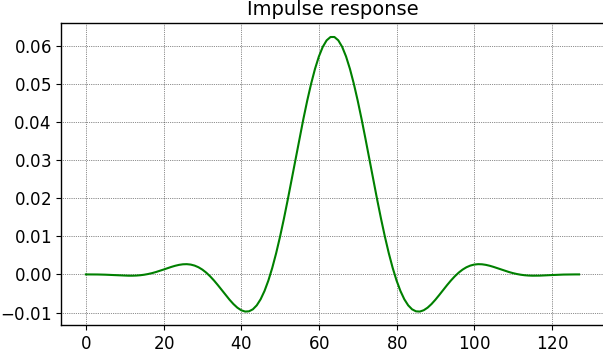

In [8]:
# Plot impulse response
plt.figure(1)
plt.plot(hPrototype, 'g')
plt.title('Impulse response')
plt.grid(True)

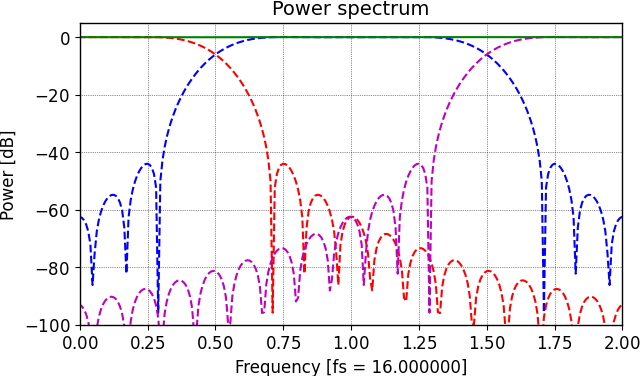

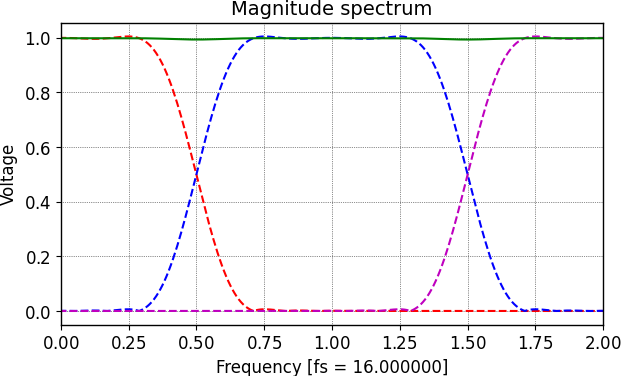

In [9]:
# Filterbank aggregate frequency response
h, f, HFprototype = dtft(hPrototype)
HFbank = filterbank_frequency_response(HFprototype, Ndft)

# Filterbank bin 1, 2 frequency responses, HFprototype is for bin 0
Lprototype = len(HFprototype)
Lbin = Lprototype // Ndft
HF1 = np.roll(HFprototype, 1*Lbin)
HF2 = np.roll(HFprototype, 2*Lbin)

# Plot transfer function (use frequency in fsub units)
fLim = None
fLim = (0, 2)
dbLim = None
dbLim = (-100, 5)
voltLim = None
plt.figure(1)
plot_power_spectrum(f, HFprototype, 'r--', fs / fsub, fLim, dbLim)  # bin 0
plot_power_spectrum(f, HF1, 'b--', fs / fsub, fLim, dbLim)  # bin 1
plot_power_spectrum(f, HF2, 'm--', fs / fsub, fLim, dbLim)  # bin 2
plot_power_spectrum(f, HFbank, 'g', fs / fsub, fLim, dbLim)  # all bins
plt.figure(2)
plot_magnitude_spectrum(f, HFprototype, 'r--', fs / fsub, fLim, voltLim)  # bin 0
plot_magnitude_spectrum(f, HF1, 'b--', fs / fsub, fLim, voltLim)  # bin 1
plot_magnitude_spectrum(f, HF2, 'm--', fs / fsub, fLim, voltLim)  # bin 2
plot_magnitude_spectrum(f, HFbank, 'g', fs / fsub, fLim, voltLim)  # all bins

# 2 Generate input data

In [10]:
# x[n] = carrier waveform
# . freq = center subband yields constant baseband I, Q signal
# . phase = 0 yields Q = 0
wgSubIsInt = is_integer_value(wg_sub)
wgFreq = wg_sub * fsub  # in Hz
wgPhase = 0.0  # in degrees
wgAmpl = 1
xData = wgAmpl * np.cos(2 * np.pi * wgFreq * n_s + np.radians(wgPhase))

In [11]:
# Additive Gaussian White Noise (AGWN)
SNR_dB = 100  # signal to noise ratio between one carrier and the noise
seed = None
seed = 1
rng = np.random.default_rng(seed)
mu = 0.0
sigma = wgAmpl * np.sqrt(0.5) / 10**(SNR_dB / 20)
noise = rng.normal(mu, sigma, Nsamples)
if SNR_dB < 100:
    xData += noise

# Check SNR, each extra carrie adds 3 dB
powCarriers = np.sum(xData**2) / Nsamples
powNoise = np.sum(noise**2) / Nsamples
snr_db = 10 * np.log10(powCarriers / powNoise)
print('powCarriers = %f' % powCarriers)
print('powNoise = %f' % powNoise)
print('SNR = %f dB' % snr_db)

powCarriers = 0.500000
powNoise = 0.000000
SNR = 100.697035 dB


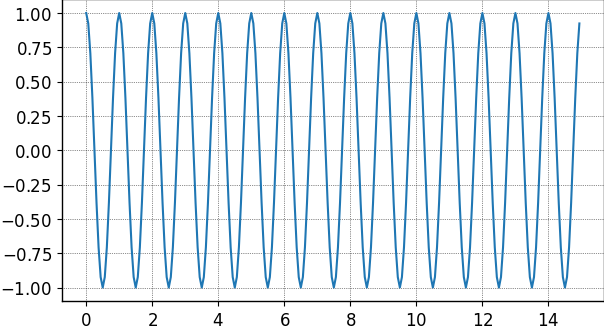

In [12]:
plt.plot(n_sub, xData)

# 3 Single channel downconverter

# 3.1 Full rate: LO --> LPF --> D

Down convert bin kLo to baseband, then LPF still at sample rate and then downsample [HARRIS Fig 6.2].

In [13]:
# Mixer local oscillator (LO) for channel k
w_k = 2 * np.pi * kLo / Ndft
LO = np.exp(-1j * w_k * n_s)

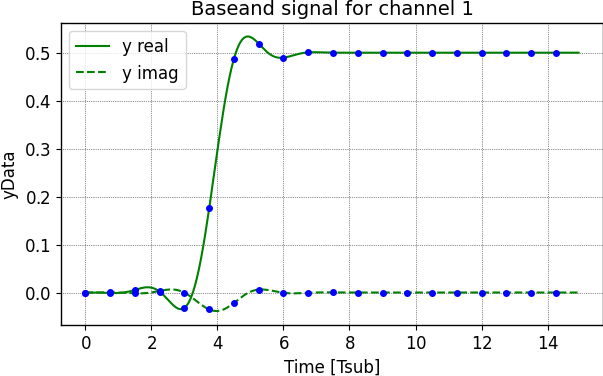

In [14]:
# x[n] --> LO --> LPF --> D --> y[mD, k] [HARRIS Fig 6.2] 
xLoData = xData * LO
yData = signal.lfilter(hPrototype, [1.0], xLoData)  # = y[n, k], Eq. 6.1
yDown = down(yData, Ndown)  # = y[mD, k]

plt.plot(n_sub, yData.real, 'g-')
plt.plot(n_sub, yData.imag, 'g--')
plt.plot(m_sub, yDown.real, 'b.')
plt.plot(m_sub, yDown.imag, 'b.')
plt.title('Baseand signal for channel %d' % kLo)
plt.xlabel('Time [Tsub]')
plt.ylabel('yData')
#plt.ylim([-0.6, 0.6])
plt.legend(['y real', 'y imag'])

## 3.2 LO at downsampled rate: BPF --> D --> LOdown

Use BPF centered at kLo (is LPF shifted by +kLo) still at sample rate, then downsample and do down conversion by from kLo to baseband at downsampled rate [HARRIS Fig 6.7].

If Ndown = Ndft, then D * w_k = D * 2pi * k / Ndft is multiple of 2pi, so then LOdown = 1.

In [15]:
x = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
x.reshape((4,3))

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11]])

In [16]:
# LO --> D --> LOdown == loD
#
#  LOdown = exp(-j * D w_k * m) = loD
#         = exp(-j * 2 pi D / Ndft * k * m)
LOdown = down(LO, Ndown)

D_w_k = Ndown * w_k
loD = np.exp(-1j * D_w_k * m_i)

print('Ndft =', Ndft)
print('Ndown =', Ndown)
print('w_k =', w_k)
print('D_w_k =', D_w_k)
print('')

# Verify that LO data rotates with w_k and LO down with D * w_k rad/s
result = np.all(np.isclose(LOdown, loD))
if not result:
    plt.plot(m_sub, LOdown.real, 'r-')
    plt.plot(m_sub, LOdown.imag, 'r--')
    plt.plot(m_sub, loD.real, 'g-')
    plt.plot(m_sub, loD.imag, 'g--')
verify_result(result)

Ndft = 16
Ndown = 12
w_k = 0.39269908169872414
D_w_k = 4.71238898038469

PASSED


In [17]:
# Verify that LOdown == 1 when Ndown == Ndft
if Ndown == Ndft:
    result = np.all(np.isclose(LOdown, 1.0))
    if not result:
        plt.plot(m_sub, LOdown.real, 'r-')
        plt.plot(m_sub, LOdown.imag, 'r--')
    verify_result(result)


In [18]:
# x[n] --> BPF --> D --> LOdown --> y[m D, k] [HARRIS Fig 6.7]
hBpf = hPrototype * np.exp(1j * w_k * np.arange(Ncoefs))
yBpfData = signal.lfilter(hBpf, [1.0], xData)
yBpfDown = down(yBpfData, Ndown)
yBpfDownLo = yBpfDown * LOdown  # = y[m D, k]

# result is True for any Ndft, Ndown, because LOdown is in equation of yBpfDownLo
result = np.all(np.isclose(yDown, yBpfDownLo))
verify_result(result)

PASSED


## 3.3 BPF and LO at downsampled rate: D --> poly BPF --> LOdown

Partition the BPF FIR filter H(z) in Ndown polyphases to have Hp(z^Ndown) per polyphase branch p, so that the down sampling can be done before the BPF by using the Noble identity.

### 3.3.1 Maximally downsampled (= critically sampled)

In [19]:
print('Ndft =', Ndft)
if Ndown == Ndft:
    yMaxDownBpf = maximal_downsample_bpf(xData, Ndown, kLo, hPrototype)
    yMaxDownBpfLo = yMaxDownBpf  # = yMaxDownBpf * LOdown, because LOdown = 1 when Ndown == Ndft

    result = np.all(np.isclose(yDown, yMaxDownBpfLo))
    if not result:
        plt.plot(m_sub, yDown.real, 'g.-')
        plt.plot(m_sub, yDown.imag, 'g.--')
        plt.plot(m_sub, yMaxDownBpfLo.real, 'r-')
        plt.plot(m_sub, yMaxDownBpfLo.imag, 'r--')
    verify_result(result)

Ndft = 16


### 3.3.2 Non-maximally downsampled (= oversampled)

> non_maximal_downsample_bpf():
  . len(x)   = 240
  . Nx       = 229
  . Nblocks  = 20
  . len(yc)  = 20
  . Ndown    = 12
  . Ndft     = 16
  . k        = 1

PASSED


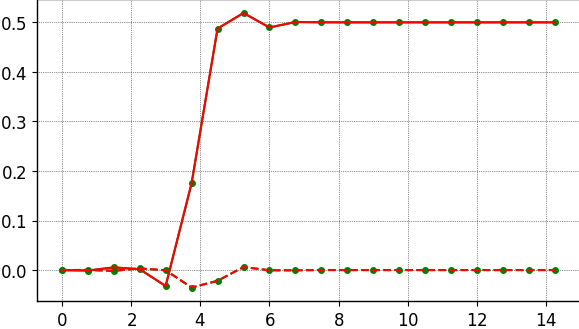

In [20]:
yDownBpf = non_maximal_downsample_bpf(xData, Ndown, kLo, Ndft, hPrototype)
yDownBpfLo = yDownBpf  # = yDownBpf * LOdown * LOshift, because LOdown = 1 when Ndown == Ndft
                       # and LOshift phase shifts compensate for time shift due to Ndown < Ndft

result = np.all(np.isclose(yDown, yDownBpfLo))
verify_result(result)

plt.plot(m_sub, yDown.real, 'g.-')
plt.plot(m_sub, yDown.imag, 'g.--')
plt.plot(m_sub, yDownBpfLo.real, 'r-')
plt.plot(m_sub, yDownBpfLo.imag, 'r--')

In [21]:
print('wg_sub =', wg_sub)
if wgSubIsInt: 
    # The phaseMargin >> c_atol, because it depends on the stop band attenuation of the
    # hPrototype LPF. This is because the LO downconverts the positive frequency band
    # of the WG cos() wave, so the negative frequency band will appear in the stop band.
    phaseMargin = 0.005
    cwPhase = np.angle(yDownBpfLo[-1], deg=True)
    print('cwPhase = %f (^= %f dB)' % (cwPhase, pow_db(cwPhase)))
    result = np.isclose(wgPhase, cwPhase, atol=phaseMargin)
    verify_result(result)

wg_sub = 1.0
cwPhase = -0.000491 (^= -66.179518 dB)
PASSED
